In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from tqdm.notebook import trange, tqdm
import torch
import torchvision
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu117
True


Dataset used: VerSe 2020 (MICCAI2020 challenge data structure) from: https://osf.io/t98fz/

In [2]:
import nibabel as nib
from torchvision import transforms

def load_nifti_to_tensor(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    tensor_data = transforms.ToTensor()(data)
    return tensor_data

X = load_nifti_to_tensor("data/verse033/verse033.nii.gz")
y = load_nifti_to_tensor("data/verse033/verse033_seg.nii.gz")

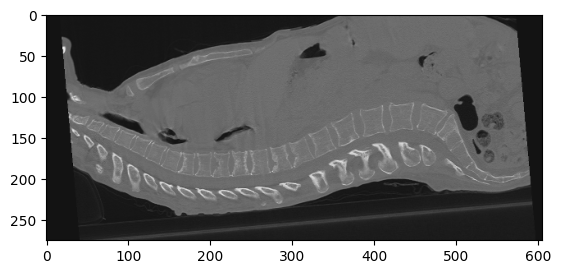

In [3]:
plt.imshow(X[40,:,:], cmap='gray')

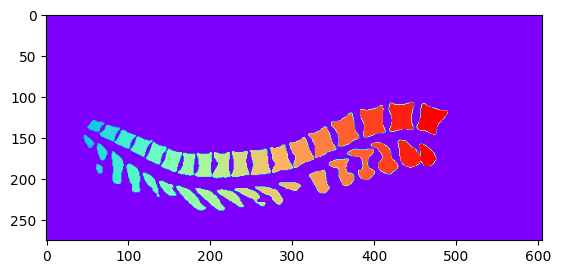

In [4]:
plt.imshow(y[40,:,:], cmap='rainbow')

The original VerSe dataset has multi-class segmentation (masks has multiple classes), but for simplicity we limit ourselves to binary classification:<br>
0: background<br>
1: vertebrae/spine<br>

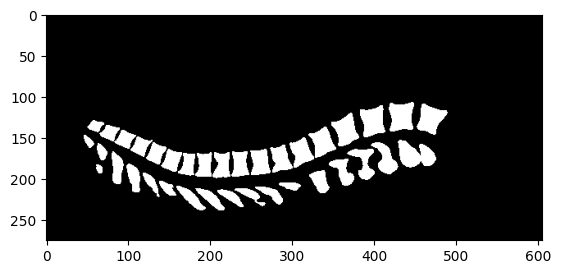

In [5]:
y_bin = torch.where(y>0, 1, 0)
plt.imshow(y_bin[40,:,:], cmap='gray')

# Building model

For educational purposes I just took U-Net, but the original is 2D segmentation.<br>

See paper for architecture https://arxiv.org/pdf/1505.04597.pdf

In [6]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x
    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p 

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        if x.shape != skip.shape:
            x = torchvision.transforms.functional.resize(x, size=skip.shape[2:])
#         print(x.shape, skip.shape)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Downsampling """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        self.b = conv_block(512, 1024)

        """ Upsampling """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Output """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0) 

    def forward(self, inputs):
        """ Downsampling """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        """ Upsampling """
        d1 = self.d1(b, s4)
#         print(f'b: {b.shape},s4: {s4.shape}')
        d2 = self.d2(d1, s3)
#         print(f'b: {d1.shape},s4: {s3.shape}')
        d3 = self.d3(d2, s2)
#         print(f'b: {d2.shape},s4: {s2.shape}')
        d4 = self.d4(d3, s1)
#         print(f'b: {d3.shape},s4: {s1.shape}')

        """ Output """
        outputs = self.outputs(d4)

        return outputs

In [7]:
print(f'Shape before: {X.shape},{y_bin.shape}')
X = X[40,:-1,:-1]
y_bin = y_bin[40,:-1,:-1]
X -= X.min()
X /= X.max()
X_batch = X.unsqueeze(0).unsqueeze(0).to(torch.float32)
y_batch = y_bin.unsqueeze(0).unsqueeze(0).to(torch.float32)
print(f'Shape after: {X_batch.shape},{y_batch.shape}')

Shape before: torch.Size([81, 275, 605]),torch.Size([81, 275, 605])
Shape after: torch.Size([1, 1, 274, 604]),torch.Size([1, 1, 274, 604])


In [8]:
print(f'Max: {torch.max(X_batch)}\nMin: {torch.min(X_batch)}')

Max: 1.0
Min: 0.0


In [9]:
from torch.utils.data import Dataset

class VerSeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
data = VerSeDataset(X_batch, y_batch)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

loader = torch.utils.data.DataLoader(data, batch_size=1)
model = unet() 
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.BCEWithLogitsLoss()

In [11]:
data[0][0].shape

torch.Size([1, 274, 604])

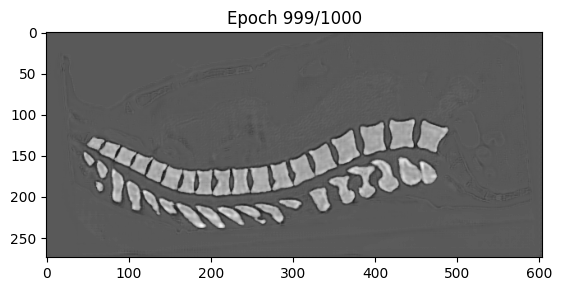

In [12]:
from IPython.display import clear_output # for animating the plot

nr_epochs = 1000
for epoch in range(nr_epochs):
    
    model.train()
    for batch, (X, y) in enumerate(loader):
        optimizer.zero_grad()   
        prediction = model(X.to(device))
        loss = loss_fn(prediction, y.to(device))
        loss.backward()
        optimizer.step()
    
#     if epoch % 5 == 0 or epoch==nr_epochs-1:
        model.eval()
        clear_output(wait=True)
        prediction = model(data[0][0].unsqueeze(0).to(device))
        plt.title(f"Epoch {epoch}/{nr_epochs}")
        plt.imshow(prediction.squeeze().squeeze().detach().cpu(), cmap='gray') 
        plt.show()


In [26]:
torch.min(prediction).item(

-35.050106048583984

In [40]:
import ipywidgets as widgets
prediction = prediction.detach().cpu()
@widgets.interact(t=(torch.min(prediction).item(), torch.max(prediction).item()))
def f(t=5):
    global thresholded
    thresholded = torch.where(prediction>t, 1, 0)
    plt.imshow(thresholded.squeeze().squeeze(), cmap='gray')


interactive(children=(FloatSlider(value=5.0, description='t', max=35.36027908325195, min=-35.050106048583984),…

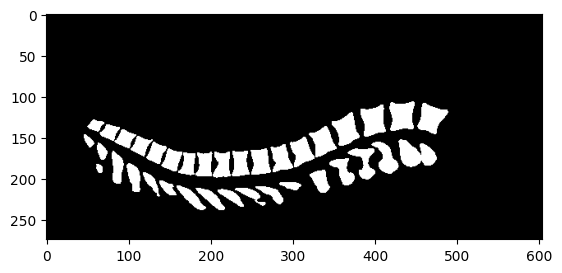

In [32]:
plt.imshow(y.squeeze().squeeze(), cmap='gray') # show label again

In [41]:
torch.sum(thresholded)

tensor(16843)

${\displaystyle DSC={\frac {2|X\cap Y|}{|X|+|Y|}}}$

In [45]:
def DSC(y_predict, y_label):
    score = 2*torch.sum(y_predict*y_label)/(torch.sum(y_predict)+torch.sum(y_label))
    return score

DSC(thresholded, y)

tensor(0.9883)

# Generalization

In [86]:
X_test = load_nifti_to_tensor("data/verse088/verse088.nii.gz")
y_test = load_nifti_to_tensor("data/verse088/verse088_seg.nii.gz")

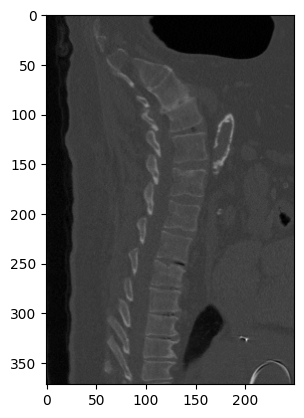

In [87]:
plt.imshow(X_test[:,120,:], cmap='gray')

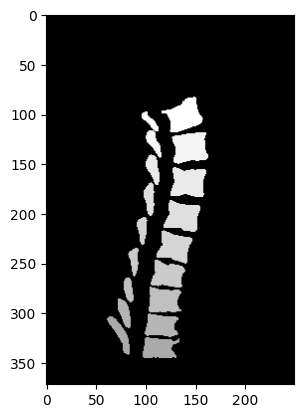

In [77]:
plt.imshow(y_test[:,120,:], cmap='gray')

In [88]:
X_test=X_test[:,120,:]
X_test -= X_test.min()
X_test /= X_test.max()

In [89]:
X_test = X_test.to(torch.float32)
X_test.max()

tensor(1.)

In [93]:
y_predict = model(X_test.unsqueeze(0).unsqueeze(0).to(device))

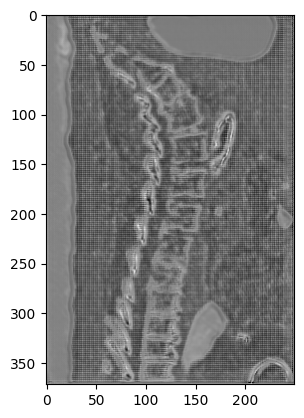

In [96]:
plt.imshow(y_predict.squeeze().squeeze().detach().cpu(), cmap='gray')